# Predicting Housing Prices

The goal of this notebook is to try and predict the SalesPrice of homes in Ames, Iowa. As per the Kaggle rules this will require some **feature engineering** as well as the usage of **Random Forest** models.

The approach I will take is as follows:
1. Import the data
2. Identify any strong correlations in the data
3. Determine if there are missing values
4. Remove features that are mostly null
5. Impute remaining features with mean data (numerical) and most frequent data (categorical)
6. Scale the data if needed


The kaggle competition page can be found [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [43]:
# data handling and prediction
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO
import matplotlib.pyplot as plt

#visualization
%matplotlib inline
import seaborn as sns
from IPython.display import Image
import pydotplus

In [30]:
housing_data_train = pd.read_csv("../data/train.csv",na_values='NA')
housing_data_test = pd.read_csv("../data/test.csv",na_values='NA')
housing_data_train.columns = map(str.lower, housing_data_train.columns)
housing_data_test.columns = map(str.lower, housing_data_test.columns)

In [31]:
housing_data_train.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Lets take a look at the stats for the numerical data**

In [33]:
housing_data_train.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Correlation
Lets take a look at the correlation of the features to see if we can identify the important ones

In [37]:
housing_data_train.corr()["saleprice"].sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
1stflrsf         0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
2ndflrsf         0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
screenporch      0.111447
poolarea         0.092404
mosold           0.046432
3ssnporch        0.044584
bsmtfinsf2      -0.011378
bsmthalfbath    -0.016844
miscval         -0.021190
id              -0.021917
lowqualfinsf    -0.025606
yrsold          -0.028923
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.128578
kitchenabvgr    -0.135907
Name: salepr

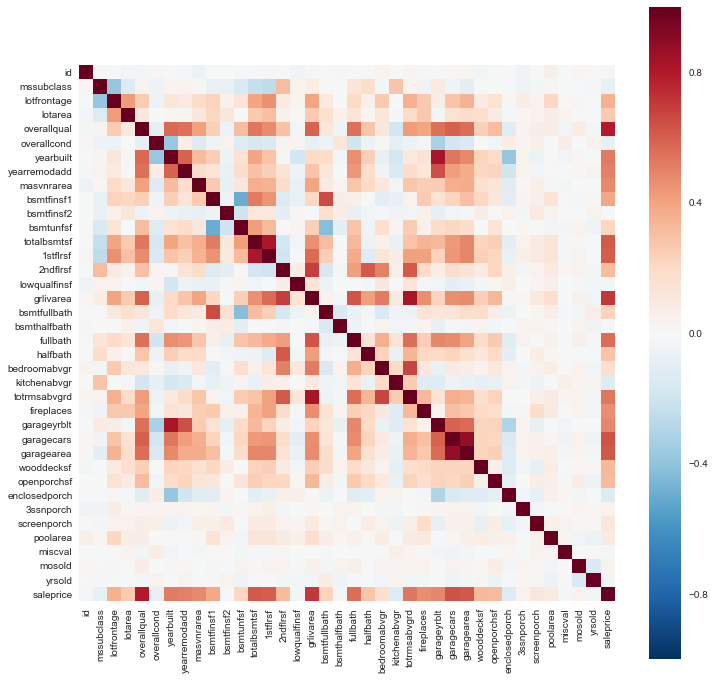

In [44]:
housing_corr = housing_data_train.corr()
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(housing_corr, square=True)

In [ ]:
# Select the fields with high correlation and then create a pairplot

Separate numeric and categorical features

In [5]:
housing_data_train_numeric = housing_data_train.select_dtypes(include=['int64','float64'])

In [6]:
housing_data_train_numeric.columns.tolist()

['id',
 'mssubclass',
 'lotfrontage',
 'lotarea',
 'overallqual',
 'overallcond',
 'yearbuilt',
 'yearremodadd',
 'masvnrarea',
 'bsmtfinsf1',
 'bsmtfinsf2',
 'bsmtunfsf',
 'totalbsmtsf',
 '1stflrsf',
 '2ndflrsf',
 'lowqualfinsf',
 'grlivarea',
 'bsmtfullbath',
 'bsmthalfbath',
 'fullbath',
 'halfbath',
 'bedroomabvgr',
 'kitchenabvgr',
 'totrmsabvgrd',
 'fireplaces',
 'garageyrblt',
 'garagecars',
 'garagearea',
 'wooddecksf',
 'openporchsf',
 'enclosedporch',
 '3ssnporch',
 'screenporch',
 'poolarea',
 'miscval',
 'mosold',
 'yrsold',
 'saleprice']

In [7]:
housing_data_train_categories = housing_data_train.select_dtypes(exclude=['int64','float64'])

In [8]:
housing_data_train_categories.columns.tolist()

['mszoning',
 'street',
 'alley',
 'lotshape',
 'landcontour',
 'utilities',
 'lotconfig',
 'landslope',
 'neighborhood',
 'condition1',
 'condition2',
 'bldgtype',
 'housestyle',
 'roofstyle',
 'roofmatl',
 'exterior1st',
 'exterior2nd',
 'masvnrtype',
 'exterqual',
 'extercond',
 'foundation',
 'bsmtqual',
 'bsmtcond',
 'bsmtexposure',
 'bsmtfintype1',
 'bsmtfintype2',
 'heating',
 'heatingqc',
 'centralair',
 'electrical',
 'kitchenqual',
 'functional',
 'fireplacequ',
 'garagetype',
 'garagefinish',
 'garagequal',
 'garagecond',
 'paveddrive',
 'poolqc',
 'fence',
 'miscfeature',
 'saletype',
 'salecondition']

In [9]:
housing_data_train_categories.head()

,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,...,garagetype,garagefinish,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,saletype,salecondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [10]:
percent_null = (housing_data_train_categories.isnull().sum()/
                housing_data_train.isnull().count())

percent_null.sort_values(ascending=False)

poolqc           0.995205
miscfeature      0.963014
alley            0.937671
fence            0.807534
fireplacequ      0.472603
garagecond       0.055479
garagefinish     0.055479
garagetype       0.055479
garagequal       0.055479
bsmtexposure     0.026027
bsmtfintype2     0.026027
bsmtqual         0.025342
bsmtcond         0.025342
bsmtfintype1     0.025342
masvnrtype       0.005479
electrical       0.000685
condition2       0.000000
exterior2nd      0.000000
exterior1st      0.000000
extercond        0.000000
mszoning         0.000000
condition1       0.000000
centralair       0.000000
saletype         0.000000
bldgtype         0.000000
exterqual        0.000000
salecondition    0.000000
neighborhood     0.000000
foundation       0.000000
functional       0.000000
                   ...   
bsmtunfsf             NaN
enclosedporch         NaN
fireplaces            NaN
fullbath              NaN
garagearea            NaN
garagecars            NaN
garageyrblt           NaN
grlivarea   

** Drop categories where the majority of the data is missing **

In [11]:
drop_columns = ['alley','poolqc','fence','miscfeature', 'fireplacequ']
for column in drop_columns:
    housing_data_train_categories = housing_data_train_categories.drop(column, axis=1)

In [12]:
numeric_percent_null = housing_data_train_numeric.isnull().sum()/housing_data_train_numeric.isnull().count()
numeric_percent_null.sort_values(ascending=False)

lotfrontage      0.177397
garageyrblt      0.055479
masvnrarea       0.005479
bsmtfinsf1       0.000000
lowqualfinsf     0.000000
2ndflrsf         0.000000
1stflrsf         0.000000
totalbsmtsf      0.000000
bsmtunfsf        0.000000
bsmtfinsf2       0.000000
saleprice        0.000000
bsmtfullbath     0.000000
yearremodadd     0.000000
yearbuilt        0.000000
overallcond      0.000000
overallqual      0.000000
lotarea          0.000000
mssubclass       0.000000
grlivarea        0.000000
bsmthalfbath     0.000000
yrsold           0.000000
fullbath         0.000000
mosold           0.000000
miscval          0.000000
poolarea         0.000000
screenporch      0.000000
3ssnporch        0.000000
enclosedporch    0.000000
openporchsf      0.000000
wooddecksf       0.000000
garagearea       0.000000
garagecars       0.000000
fireplaces       0.000000
totrmsabvgrd     0.000000
kitchenabvgr     0.000000
bedroomabvgr     0.000000
halfbath         0.000000
id               0.000000
dtype: float

**Drop numerical data what is missing a significant percentage**

In [13]:
housing_data_train_numeric = housing_data_train_numeric.drop('lotfrontage', axis=1)

In [14]:
housing_data_train_numeric.columns.tolist()

['id',
 'mssubclass',
 'lotarea',
 'overallqual',
 'overallcond',
 'yearbuilt',
 'yearremodadd',
 'masvnrarea',
 'bsmtfinsf1',
 'bsmtfinsf2',
 'bsmtunfsf',
 'totalbsmtsf',
 '1stflrsf',
 '2ndflrsf',
 'lowqualfinsf',
 'grlivarea',
 'bsmtfullbath',
 'bsmthalfbath',
 'fullbath',
 'halfbath',
 'bedroomabvgr',
 'kitchenabvgr',
 'totrmsabvgrd',
 'fireplaces',
 'garageyrblt',
 'garagecars',
 'garagearea',
 'wooddecksf',
 'openporchsf',
 'enclosedporch',
 '3ssnporch',
 'screenporch',
 'poolarea',
 'miscval',
 'mosold',
 'yrsold',
 'saleprice']

In [15]:
housing_data_train_numeric.describe

<bound method NDFrame.describe of         id  mssubclass  lotarea  overallqual  overallcond  yearbuilt  \
0        1          60     8450            7            5       2003   
1        2          20     9600            6            8       1976   
2        3          60    11250            7            5       2001   
3        4          70     9550            7            5       1915   
4        5          60    14260            8            5       2000   
5        6          50    14115            5            5       1993   
6        7          20    10084            8            5       2004   
7        8          60    10382            7            6       1973   
8        9          50     6120            7            5       1931   
9       10         190     7420            5            6       1939   
10      11          20    11200            5            5       1965   
11      12          60    11924            9            5       2005   
12      13          20    1296

In [16]:
housing_data_train_categories.describe()

,mszoning,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,...,electrical,kitchenqual,functional,garagetype,garagefinish,garagequal,garagecond,paveddrive,saletype,salecondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1459,1460,1460,1379,1379,1379,1379,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,...,5,4,7,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,...,1334,735,1360,870,605,1311,1326,1340,1267,1198


**Fill the numeric missing data with the mean**

In [17]:
mean_per_column = housing_data_train_numeric.apply(lambda x: x.mean(),axis=0)
numeric_mean_filled = housing_data_train_numeric.fillna(mean_per_column,axis=0)
numeric_mean_filled.isnull().sum()

id               0
mssubclass       0
lotarea          0
overallqual      0
overallcond      0
yearbuilt        0
yearremodadd     0
masvnrarea       0
bsmtfinsf1       0
bsmtfinsf2       0
bsmtunfsf        0
totalbsmtsf      0
1stflrsf         0
2ndflrsf         0
lowqualfinsf     0
grlivarea        0
bsmtfullbath     0
bsmthalfbath     0
fullbath         0
halfbath         0
bedroomabvgr     0
kitchenabvgr     0
totrmsabvgrd     0
fireplaces       0
garageyrblt      0
garagecars       0
garagearea       0
wooddecksf       0
openporchsf      0
enclosedporch    0
3ssnporch        0
screenporch      0
poolarea         0
miscval          0
mosold           0
yrsold           0
saleprice        0
dtype: int64

** Impute most frequent values in categorical data**

In [18]:
def get_most_frequent_value (column):
    return column.value_counts().index[0]

most_frequent_values = housing_data_train_categories.apply(get_most_frequent_value,axis=0)

In [19]:
most_frequent_values = housing_data_train_categories.apply(get_most_frequent_value,axis=0)
print("Most frequent value in each column:\n"),most_frequent_values

Most frequent value in each column:



(None, mszoning              RL
 street              Pave
 lotshape             Reg
 landcontour          Lvl
 utilities         AllPub
 lotconfig         Inside
 landslope            Gtl
 neighborhood       NAmes
 condition1          Norm
 condition2          Norm
 bldgtype            1Fam
 housestyle        1Story
 roofstyle          Gable
 roofmatl         CompShg
 exterior1st      VinylSd
 exterior2nd      VinylSd
 masvnrtype          None
 exterqual             TA
 extercond             TA
 foundation         PConc
 bsmtqual              TA
 bsmtcond              TA
 bsmtexposure          No
 bsmtfintype1         Unf
 bsmtfintype2         Unf
 heating             GasA
 heatingqc             Ex
 centralair             Y
 electrical         SBrkr
 kitchenqual           TA
 functional           Typ
 garagetype        Attchd
 garagefinish         Unf
 garagequal            TA
 garagecond            TA
 paveddrive             Y
 saletype              WD
 salecondition     Normal
 dtype

In [20]:
categorical_most_frequent = housing_data_train_categories.fillna(most_frequent_values,axis=0)

In [21]:
categorical_most_frequent.isnull().sum()

mszoning         0
street           0
lotshape         0
landcontour      0
utilities        0
lotconfig        0
landslope        0
neighborhood     0
condition1       0
condition2       0
bldgtype         0
housestyle       0
roofstyle        0
roofmatl         0
exterior1st      0
exterior2nd      0
masvnrtype       0
exterqual        0
extercond        0
foundation       0
bsmtqual         0
bsmtcond         0
bsmtexposure     0
bsmtfintype1     0
bsmtfintype2     0
heating          0
heatingqc        0
centralair       0
electrical       0
kitchenqual      0
functional       0
garagetype       0
garagefinish     0
garagequal       0
garagecond       0
paveddrive       0
saletype         0
salecondition    0
dtype: int64

**Transform the categorical fields using get_dummies function**

In [22]:
categorical_list = categorical_most_frequent.columns.tolist()
housing_dummies = pd.get_dummies(categorical_most_frequent,columns=categorical_list)
housing_dummies.head()

,mszoning_C (all),mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Grvl,street_Pave,lotshape_IR1,lotshape_IR2,lotshape_IR3,...,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [23]:
all_housing_data_mean = pd.concat((numeric_mean_filled,housing_dummies),axis=1)

In [24]:
all_housing_data_mean.head()

,id,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,...,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,1,60,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,2,20,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,3,60,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,4,70,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,5,60,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0


In [25]:
all_housing_data_mean.shape

(1460, 271)